In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load the data
df_resampled = pd.read_csv('../../data/processed/heart_resampled_se.csv')
df = pd.read_csv('../../data/processed/heart_se.csv')

In [3]:
# Split the data into features and target variable
X = df.drop(['target','index'], axis=1)
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # Assuming a binary classification problem

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.sigmoid(self.output_layer(x))
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)

criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Test the model
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    accuracy = correct / total
    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/50], Loss: 0.7009
Epoch [2/50], Loss: 0.6931
Epoch [3/50], Loss: 0.6816
Epoch [4/50], Loss: 0.6672
Epoch [5/50], Loss: 0.6394
Epoch [6/50], Loss: 0.6045
Epoch [7/50], Loss: 0.5558
Epoch [8/50], Loss: 0.4906
Epoch [9/50], Loss: 0.4238
Epoch [10/50], Loss: 0.3745
Epoch [11/50], Loss: 0.3510
Epoch [12/50], Loss: 0.3208
Epoch [13/50], Loss: 0.3170
Epoch [14/50], Loss: 0.3252
Epoch [15/50], Loss: 0.3167
Epoch [16/50], Loss: 0.2887
Epoch [17/50], Loss: 0.3001
Epoch [18/50], Loss: 0.3012
Epoch [19/50], Loss: 0.2791
Epoch [20/50], Loss: 0.2930
Epoch [21/50], Loss: 0.2749
Epoch [22/50], Loss: 0.2612
Epoch [23/50], Loss: 0.2634
Epoch [24/50], Loss: 0.2646
Epoch [25/50], Loss: 0.2532
Epoch [26/50], Loss: 0.2499
Epoch [27/50], Loss: 0.2447
Epoch [28/50], Loss: 0.2299
Epoch [29/50], Loss: 0.2339
Epoch [30/50], Loss: 0.2302
Epoch [31/50], Loss: 0.2258
Epoch [32/50], Loss: 0.2339
Epoch [33/50], Loss: 0.2113
Epoch [34/50], Loss: 0.2191
Epoch [35/50], Loss: 0.1993
Epoch [36/50], Loss: 0.2148
E

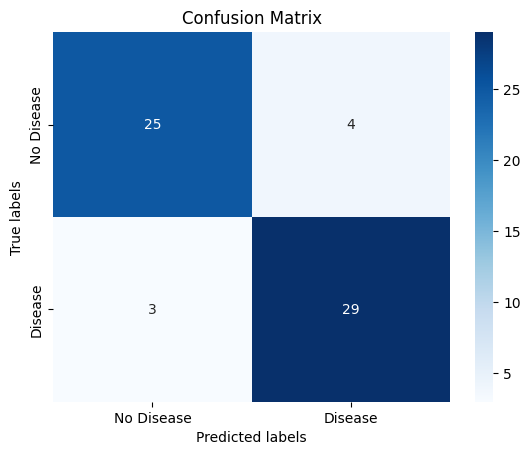

In [7]:
#plot confusion matrix with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze()
    y_pred = (y_pred > 0.5).float()
    y_pred = y_pred.numpy()
    y_test = y_test_tensor.numpy()

cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No Disease', 'Disease'])
ax.yaxis.set_ticklabels(['No Disease', 'Disease'])
plt.show()





In [23]:
import optuna
# Define the neural network model inside an objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []
    input_size = X_train.shape[1]
    
    for i in range(n_layers):
        num_hidden_units = trial.suggest_int(f'n_units_l{i}', 16, 128)
        layers.append(nn.Linear(input_size, num_hidden_units))
        layers.append(nn.ReLU())
        input_size = num_hidden_units
    
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())  # Assuming binary classification
    
    model = nn.Sequential(*layers)
    
    # Suggest optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD', 'Adadelta', 'Adagrad', 'AdamW'])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    # Define loss function
    criterion = nn.BCELoss()
    
    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    accuracy = correct / total
    return accuracy

# Optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Print best trial
print("Best trial:")
trial = study.best_trial

print(f"  Accuracy: {trial.value}")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-08-27 16:28:33,800] A new study created in memory with name: no-name-1550603e-f8d8-4177-a0e8-24d57154ac87
/var/folders/y0/8vyv832s3696sxgrt2_3v0k40000gn/T/ipykernel_91010/1022802541.py:22: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-08-27 16:28:33,862] Trial 0 finished with value: 0.819672131147541 and parameters: {'n_layers': 2, 'n_units_l0': 110, 'n_units_l1': 102, 'optimizer': 'Adam', 'lr': 0.01862066174029776}. Best is trial 0 with value: 0.819672131147541.
[I 2024-08-27 16:28:33,902] Trial 1 finished with value: 0.3442622950819672 and parameters: {'n_layers': 1, 'n_units_l0': 84, 'optimizer': 'RMSprop', 'lr': 1.2540279631991233e-05}. Best is trial 0 with value: 0.819672131147541.
[I 2024-08-27 16:28:33,963] Trial 2 finished with value: 0.8688524590163934 and parameters: {'n_layers': 3, 'n_units_l0': 25, '

Best trial:
  Accuracy: 0.9180327868852459
  Best hyperparameters: 
    n_layers: 3
    n_units_l0: 24
    n_units_l1: 45
    n_units_l2: 56
    optimizer: SGD
    lr: 0.06152644905044533


In [19]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Plot the optimization history
opt_history = plot_optimization_history(study)
opt_history.show()



In [20]:
# Plot the hyperparameter importances
param_importance = plot_param_importances(study)
param_importance.show()

In [21]:

# Plot the parallel coordinate plot to visualize hyperparameter interactions
parallel_coordinate = plot_parallel_coordinate(study)
parallel_coordinate.show()



In [22]:
# Plot the slice plot for each hyperparameter
slice_plot = plot_slice(study)
slice_plot.show()